## **Importing libraries and datasets**

In [44]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df_response = pd.read_csv('drive/My Drive/Retail_Data_Response.csv')
df_transactions = pd.read_csv('drive/My Drive/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [47]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [48]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [49]:
#เลือกเอาข้อมูลแค่ 2 ปี
df_transactions = df_transactions[(df_transactions['trans_date']>= '2013-03-16')]
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2013-03-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [50]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
9,CS3802,2013-08-20,75,574.0


In [51]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency ล่าสุด
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum() ,                # Monetary Value
                                                     'trans_date' : lambda x : (x.max() - x.min()).days}) 

df_rfm.rename(columns={'recent': 'recency', 
                        'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value',
                         'trans_date' : 'aou'}, inplace=True)

df_rfm['ticket_size'] = df_rfm['monetary_value']/df_rfm['frequency']

In [52]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,aou,ticket_size
0,CS1112,62.0,6,358,562,59.666667
1,CS1113,36.0,11,775,660,70.454545
2,CS1114,33.0,11,804,626,73.090909
3,CS1115,12.0,11,831,715,75.545455
4,CS1116,204.0,5,333,199,66.600000


## **Calculating response rate**

In [53]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


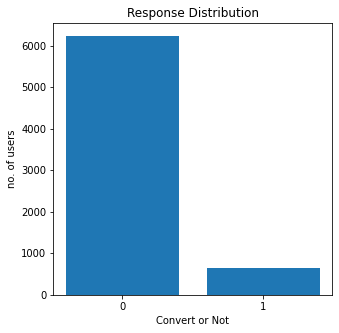

In [54]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [55]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value,aou,ticket_size
0,CS1112,0,62.0,6,358,562,59.666667
1,CS1113,0,36.0,11,775,660,70.454545
2,CS1114,1,33.0,11,804,626,73.090909
3,CS1115,1,12.0,11,831,715,75.545455
4,CS1116,1,204.0,5,333,199,66.600000


In [56]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 5)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 5)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

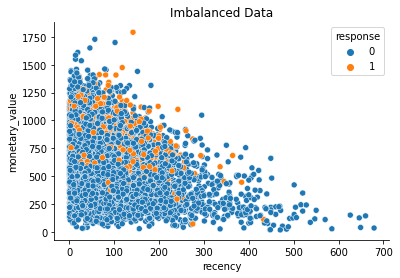

In [58]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

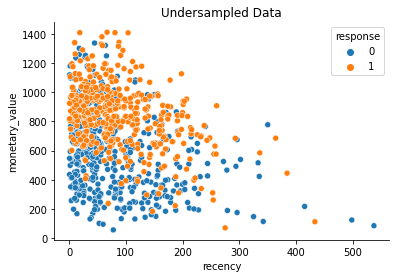

In [59]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value','AOU','Ticket_Size', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

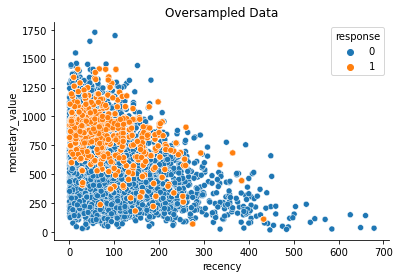

In [60]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value','AOU','Ticket_Size', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

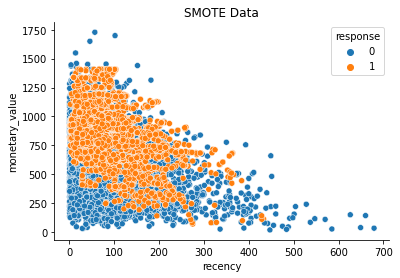

In [61]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value','AOU','Ticket_Size', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [62]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       429
           1       0.72      0.76      0.74       429

    accuracy                           0.73       858
   macro avg       0.74      0.73      0.73       858
weighted avg       0.74      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.23      0.78      0.35       218

    accuracy                           0.70      2066
   macro avg       0.60      0.74      0.58      2066
weighted avg       0.89      0.70      0.76      2066



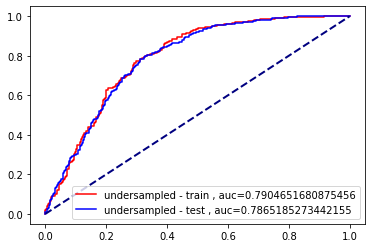

In [63]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [64]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 6.14539862e-03 -1.15053842e-01  6.59766226e-03  5.64028678e-05
  -2.61357384e-02]] [-2.28339339]


In [65]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      4389
           1       0.71      0.74      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.81      1848
           1       0.23      0.76      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.73      0.58      2066
weighted avg       0.88      0.70      0.76      2066



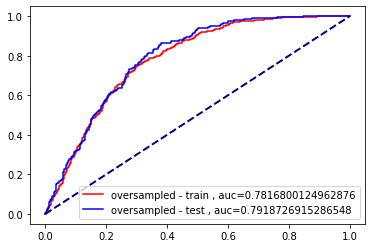

In [66]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [67]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.00488274 -0.04443489  0.00572249 -0.00140266 -0.02602707]] [-2.28339339]


In [68]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      4389
           1       0.71      0.76      0.74      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.23      0.78      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.58      2066
weighted avg       0.89      0.69      0.75      2066



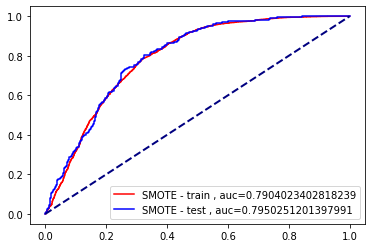

In [69]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [70]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[7.65621192e-03 3.30326394e-01 1.05417843e-04 8.13105023e-04
  3.24668962e-02]] [-2.28339339]


## **XGBoost**

In [71]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.781399
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.794282
[2]	validation_0-auc:0.795155
[3]	validation_0-auc:0.795767
[4]	validation_0-auc:0.795411
[5]	validation_0-auc:0.798334
[6]	validation_0-auc:0.799669
[7]	validation_0-auc:0.798988
[8]	validation_0-auc:0.801581
[9]	validation_0-auc:0.802318
[10]	validation_0-auc:0.802261
[11]	validation_0-auc:0.803069
[12]	validation_0-auc:0.804002
[13]	validation_0-auc:0.803722
[14]	validation_0-auc:0.805119
[15]	validation_0-auc:0.804758
[16]	validation_0-auc:0.802871
[17]	validation_0-auc:0.80233
[18]	validation_0-auc:0.803293
[19]	validation_0-auc:0.803818
Stopping. Best iteration:
[14]	validation_0-auc:0.805119

training set
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       429
           1       0.72      0.85      0.78       429

    accuracy                           0.76       858
   macro a

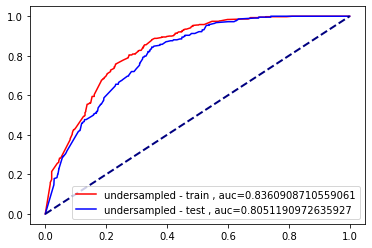

In [72]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

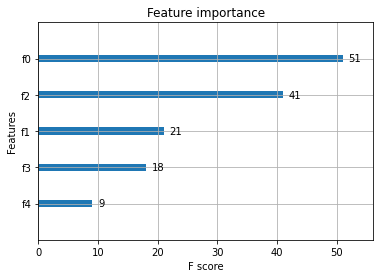

In [73]:
xgb.plot_importance(xgb_model_under)

In [74]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.790258
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.792215
[2]	validation_0-auc:0.795664
[3]	validation_0-auc:0.802155
[4]	validation_0-auc:0.801036
[5]	validation_0-auc:0.799262
[6]	validation_0-auc:0.79885
[7]	validation_0-auc:0.799704
[8]	validation_0-auc:0.801921
Stopping. Best iteration:
[3]	validation_0-auc:0.802155

training set
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      4389
           1       0.71      0.83      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75      8778
weighted avg       0.76      0.75      0.75      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      1848
           1       0.22      0.82      0.35       218

    accuracy                           0.68      2066
   macro avg    

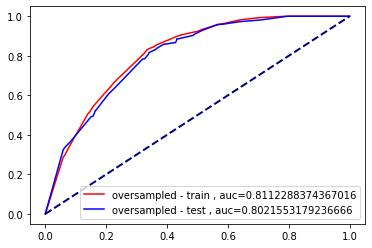

In [75]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

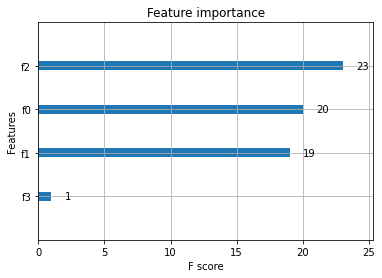

In [76]:
xgb.plot_importance(xgb_model_over)

In [77]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.774192
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.775738
[2]	validation_0-auc:0.788077
[3]	validation_0-auc:0.791355
[4]	validation_0-auc:0.790157
[5]	validation_0-auc:0.793342
[6]	validation_0-auc:0.800217
[7]	validation_0-auc:0.801244
[8]	validation_0-auc:0.801757
[9]	validation_0-auc:0.800707
[10]	validation_0-auc:0.801702
[11]	validation_0-auc:0.801819
[12]	validation_0-auc:0.802291
[13]	validation_0-auc:0.80186
[14]	validation_0-auc:0.802191
[15]	validation_0-auc:0.80242
[16]	validation_0-auc:0.79876
[17]	validation_0-auc:0.803152
[18]	validation_0-auc:0.802934
[19]	validation_0-auc:0.800424
[20]	validation_0-auc:0.800451
[21]	validation_0-auc:0.801653
[22]	validation_0-auc:0.803025
Stopping. Best iteration:
[17]	validation_0-auc:0.803152

training set
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      4389
           1       0.76      0.87  

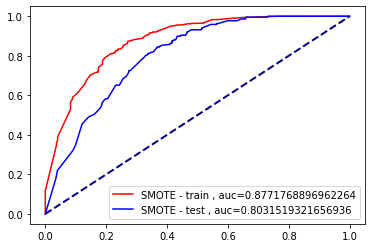

In [78]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

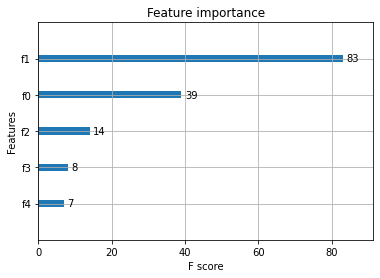

In [79]:
xgb.plot_importance(xgb_model_SMOTE)

In [80]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.764182
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.776555
[2]	validation_0-auc:0.789863
[3]	validation_0-auc:0.783313
[4]	validation_0-auc:0.787523
[5]	validation_0-auc:0.783061
[6]	validation_0-auc:0.788008
[7]	validation_0-auc:0.786658
Stopping. Best iteration:
[2]	validation_0-auc:0.789863

training set
              precision    recall  f1-score   support

           0       0.86      0.64      0.73      4389
           1       0.71      0.89      0.79      4389

    accuracy                           0.77      8778
   macro avg       0.78      0.77      0.76      8778
weighted avg       0.78      0.77      0.76      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1848
           1       0.21      0.81      0.34       218

    accuracy                           0.66      2066
   macro avg       0.59      0.7

## **Decision Tree**

In [81]:
#Decision Tree for Undersampled
print('decision tree model - undersampled')

predicted_y = []
expected_y = []

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree_under = decision_tree.fit(X_undersampled, y_undersampled)
predictions = decision_tree_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = decision_tree_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

decision tree model - undersampled
training set
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       429
           1       0.73      0.82      0.77       429

    accuracy                           0.75       858
   macro avg       0.76      0.75      0.75       858
weighted avg       0.76      0.75      0.75       858

test set
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      1848
           1       0.22      0.82      0.35       218

    accuracy                           0.68      2066
   macro avg       0.60      0.74      0.57      2066
weighted avg       0.89      0.68      0.74      2066



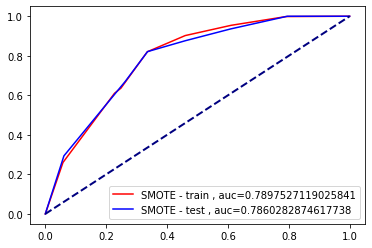

In [82]:
y_score_train = decision_tree_under.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = decision_tree_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [83]:
#Decision Tree for Oversampled
print('decision tree model - oversampled')

predicted_y = []
expected_y = []

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree_over = decision_tree.fit(X_oversampled, y_oversampled)
predictions = decision_tree_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = decision_tree_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

decision tree model - oversampled
training set
              precision    recall  f1-score   support

           0       0.82      0.62      0.70      4389
           1       0.69      0.86      0.77      4389

    accuracy                           0.74      8778
   macro avg       0.75      0.74      0.74      8778
weighted avg       0.75      0.74      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1848
           1       0.21      0.84      0.33       218

    accuracy                           0.64      2066
   macro avg       0.59      0.73      0.54      2066
weighted avg       0.89      0.64      0.71      2066



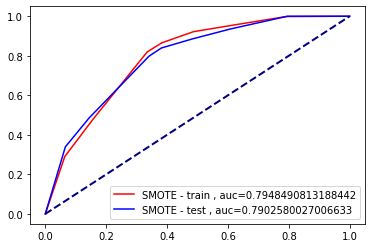

In [84]:
y_score_train = decision_tree_over.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = decision_tree_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [85]:
#Decision Tree for SMOTE
print('decision tree model - SMOTE')

predicted_y = []
expected_y = []

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree_SMOTE = decision_tree.fit(X_SMOTE, y_oversampled)
predictions = decision_tree_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = decision_tree_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

decision tree model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      4389
           1       0.72      0.82      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75      8778
weighted avg       0.76      0.75      0.75      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.23      0.79      0.35       218

    accuracy                           0.69      2066
   macro avg       0.60      0.74      0.58      2066
weighted avg       0.89      0.69      0.75      2066



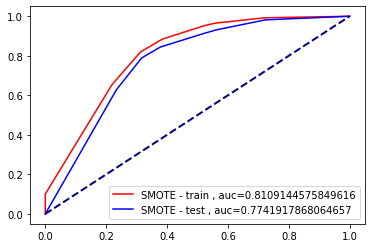

In [86]:
y_score_train = decision_tree_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = decision_tree_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()